# WTCHG codemonkeys 13 June 2016 - Exploratory analysis of large-scale genome variation data with [scikit-allel](http://scikit-allel.readthedocs.org) and other Python scientific libraries - Part 1 (lightning tour)

## Preamble

This notebook contains a brief tour of some exploratory analyses that can be performed on large-scale genome variation data using [scikit-allel](http://scikit-allel.readthedocs.org) in combination with general purpose Python scientific libraries such as [numpy](http://numpy.org), [pandas](http://pandas.pydata.org), [matplotlib](http://matplotlib.org), etc.

### Motivation

In the [Ag1000G](http://www.malariagen.net/ag1000g) project (phase 1) we have whole-genome sequence data from 765 individual mosquitoes collected from 8 different countries across Africa. We have used a [standard approach](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC3083463/?tool=pmcentrez) to find putative genetic differences between each individual mosquito and the reference genome sequence. The raw (i.e., unfiltered) data on genetic variantion contains more than 90 million single nucleotide polymorphisms (SNPs).

There are a range of analyses we'd like to perform with these data. The raw data are noisy and so we need to identify poor quality features within the data and design filters. After we've dealt with data quality, we would like to learn about the different populations that these mosquitoes came from. For example, are these populations genetically different from each other, and have any genes have come under recent selection (e.g., due to insecticides).

These are rich data and there are many ways they could be explored. The goal of [scikit-allel]() is to help speed up this exploration process by providing a toolkit for data manipulation and descriptive statistics. In particular, we would like to enable interactive analysis of large scale data on commodity hardware. This means that functions should be able to run on ~100 million genetic variants in ~1000 individuals on a medium spec desktop or laptop computer and return in seconds or at most minutes. I.e., you can analyse data wherever you are (at your desk, on a train, ...) and only the occasional tea break should be required.

### About this tour

The goal of this tour is to give a flavour of:

* What types of analysis are possible
* How much coding is required
* How fast stuff runs

For more information see the [scikit-allel docs](http://scikit-allel.readthedocs.org).

## Setup

Let's import the libraries we'll be using.

In [1]:
import numpy as np
import scipy
import pandas
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
sns.set_context('talk')
import h5py
import allel

The data we'll be analysing originally came from a [VCF format file](https://en.wikipedia.org/wiki/Variant_Call_Format), however these data have previously been pre-processed into an [HDF5 file](https://www.hdfgroup.org/HDF5/) which improves data access speed for a range of access patterns. I won't cover this pre-processing step here, for more information see [vcfnp](https://github.com/alimanfoo/vcfnp). 

Open an HDF5 file containing variant calls from the [Ag1000G project phase 1 AR3 data release](https://www.malariagen.net/data/ag1000g-phase1-ar3). Note that this contains **raw data**, i.e., all putative SNPs are included. As part of the Ag1000G project we have done a detailed analysis of data quality and so this dataset already contains filter annotations to tell you which SNPs we believe are real. However, for the purpose of this tour, I am going to pretend that we have never seen these data before, and so need to perform our own analysis of data quality.

In [2]:
callset_fn = '/data/coluzzi/ag1000g/data/phase1/release/AR3/variation/main/hdf5/ag1000g.phase1.ar3.h5'
callset = h5py.File(callset_fn, mode='r')
callset

<HDF5 file "ag1000g.phase1.ar3.h5" (mode r)>

Pick a chromosome arm to work with.

In [3]:
chrom = '3L'

## Visualize variant density

As a first step into getting to know these data, let's make a plot of variant density, which will simply show us how many SNPs there are and how they are distributed along the chromosome.

The data on SNP positions and various other attributes of the SNPs are stored in the HDF5 file. Each of these can be treated as a column in a table, so let's set up a table with some of the columns we'll need for this and subsequent analyses.

In [4]:
variants = allel.VariantChunkedTable(callset[chrom]['variants'], 
                                     names=['POS', 'REF', 'ALT', 'DP', 'MQ', 'QD', 'num_alleles'],
                                     index='POS')
variants

POS,REF,ALT,DP,MQ,QD,num_alleles
15,b'G',[b'T' b'' b''],1,14.5,24.188,2
19,b'A',[b'C' b'' b''],2,14.5,21.672,2
20,b'A',[b'G' b'' b''],2,14.5,21.672,2
23,b'A',[b'C' b'' b''],2,13.672,21.672,2
24,b'C',[b'A' b'' b''],2,13.672,21.672,2


The caption for this table tells us that we have 16,437,135 SNPs (rows) in this dataset.

Now let's extract the variant positions and load into a numpy array.

In [5]:
pos = variants['POS'][:]
pos

array([      15,       19,       20, ..., 41963184, 41963288, 41963345], dtype=int32)

Define a function to plot variant density in windows over the chromosome.

In [6]:
def plot_windowed_variant_density(pos, window_size, title=None):
    
    # setup windows 
    bins = np.arange(0, pos.max(), window_size)
    
    # use window midpoints as x coordinate
    x = (bins[1:] + bins[:-1])/2
    
    # compute variant density in each window
    h, _ = np.histogram(pos, bins=bins)
    y = h / window_size
    
    # plot
    fig, ax = plt.subplots(figsize=(12, 3))
    sns.despine(ax=ax, offset=10)
    ax.plot(x, y)
    ax.set_xlabel('Chromosome position (bp)')
    ax.set_ylabel('Variant density (bp$^{-1}$)')
    if title:
        ax.set_title(title)


Now make a plot with the SNP positions from our chosen chromosome.

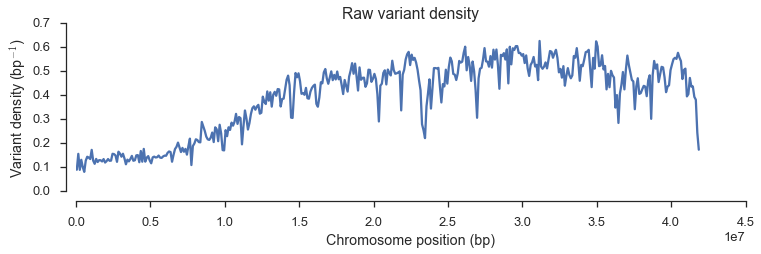

In [7]:
plot_windowed_variant_density(pos, window_size=100000, title='Raw variant density')

From this we can see that variant density is around 0.5 over much of the chromosome, which means the raw data contains a SNP about every 2 bases of the reference genome.

## Explore variant attributes

As I mentioned above, each SNP also has a number "annotations", which are data attributes that originally came from the "INFO" field in the VCF file. These are important for data quality, so let's begin by getting to know a bit more about the numerical range and distribution of some of these attributes.

Each attribute can be loaded from the table we setup earlier into a numpy array. E.g., load the "DP" field into an array.

In [10]:
dp = variants['DP'][:]
dp

array([    1,     2,     2, ..., 10092,  3072,  1485], dtype=int32)

Define a function to plot a frequency distribution for any variant attribute.

In [11]:
def plot_variant_hist(f, bins=30):
    x = variants[f][:]
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.despine(ax=ax, offset=10)
    ax.hist(x, bins=bins)
    ax.set_xlabel(f)
    ax.set_ylabel('No. variants')
    ax.set_title('Variant %s distribution' % f)


"DP" is total depth of coverage across all samples.

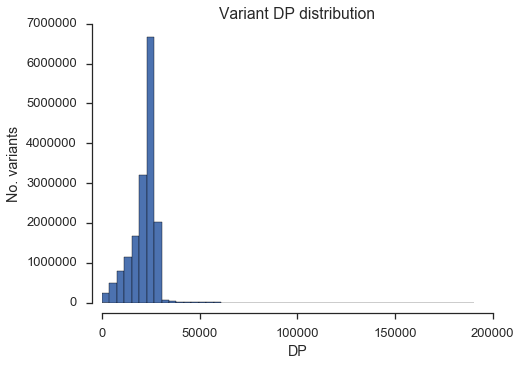

In [12]:
plot_variant_hist('DP', bins=50)

"MQ" is average mapping quality across all samples.

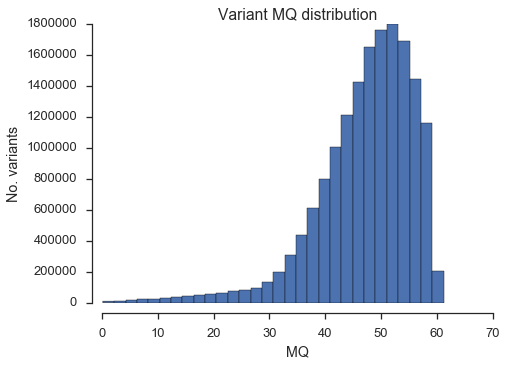

In [13]:
plot_variant_hist('MQ')

"QD" is a slightly odd statistic but turns out to be very useful for finding poor quality SNPs. Roughly speaking, high numbers mean that evidence for variation is strong (concentrated), low numbers mean that evidence is weak (dilute).

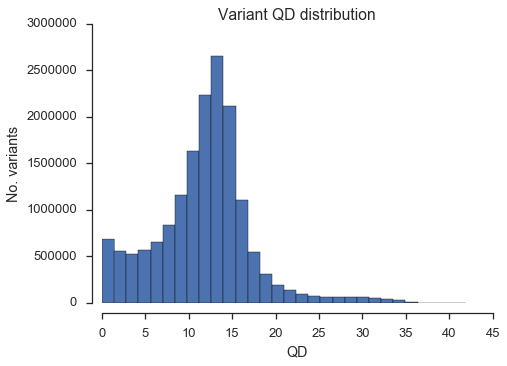

In [14]:
plot_variant_hist('QD')

Finally let's see how many biallelic, triallelic and quadriallelic SNPs we have.

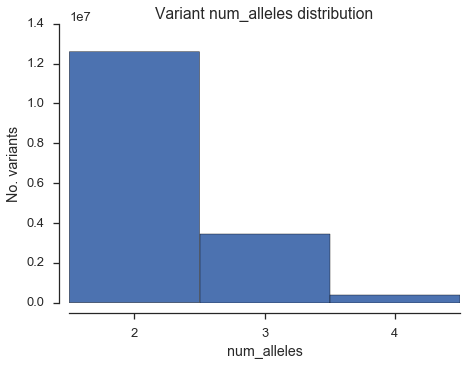

In [15]:
plot_variant_hist('num_alleles', bins=np.arange(1.5, 5.5, 1))
plt.gca().set_xticks([2, 3, 4]);

We can also look at the joint frequency distribution of two attributes.

In [16]:
def plot_variant_hist_2d(f1, f2, downsample):
    x = variants[f1][:][::downsample]
    y = variants[f2][:][::downsample]
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.despine(ax=ax, offset=10)
    ax.hexbin(x, y, gridsize=40)
    ax.set_xlabel(f1)
    ax.set_ylabel(f2)
    ax.set_title('Variant %s versus %s joint distribution' % (f1, f2))

To make the plotting go faster I've downsampled to use every 10th variant.

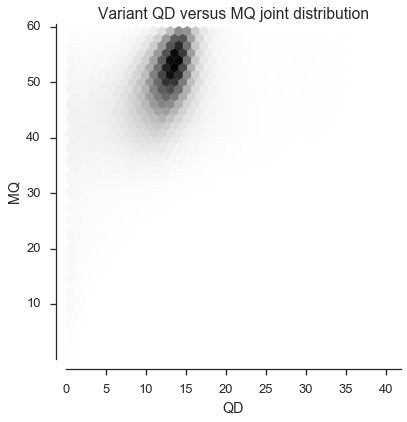

In [17]:
plot_variant_hist_2d('QD', 'MQ', downsample=10)

## Investigate variant quality

The DP, MQ and QD attributes are potentially informative about SNP quality. For example, we have a prior expectation that putative SNPs with very high or very low DP may coincide with some form of larger structural variation, and may therefore be unreliable. However, it would be great to have some empirical indicator of data quality, which could guide our choices about how to filter the data.

There are several possible quality indicators that could be used, and in general it's a good idea to use more than one if available. Here, to illustrate the general idea, let's use just one indicator, which is the number of [transitions]() divided by the number of [transversions](), which I will call Ti/Tv.

![Transitions and transversions](https://upload.wikimedia.org/wikipedia/commons/thumb/5/5b/Transitions-transversions-v4.svg/500px-Transitions-transversions-v4.svg.png)

If mutations were completely random we would expect a Ti/Tv of 0.5, because there are twice as many possible transversions as transitions. However, in most species a mutation bias has been found towards transitions, and so we expect the true Ti/Tv to be higher. We can therefore look for features of the raw data that are associated with low Ti/Tv (close to 0.5) and be fairly confident that these contain a lot of noise. 

To do this, let's first set up an array of mutations, where each entry contains two characters representing the reference and alternate allele. For simplicity of presentation I'm going to ignore the fact that some SNPs are multiallelic, but if doing this for real this should be restricted to biallelic variants only.

In [20]:
refalt = np.char.add(variants['REF'], variants['ALT'][:, 0])
refalt

array([b'GT', b'AC', b'AG', ..., b'AT', b'AC', b'AT'], 
      dtype='|S2')

Define a function to locate transition mutations within a mutations array.

In [21]:
def locate_transitions(x):
    x = np.asarray(x)
    return (x == b'AG') | (x == b'GA') | (x == b'CT') | (x == b'TC')

Demonstrate how the ``locate_transitions`` function generates a boolean array from a mutations array.

In [22]:
is_ti = locate_transitions(refalt)
is_ti

array([False, False,  True, ..., False, False, False], dtype=bool)

Define a function to compute Ti/Tv.

In [23]:
def ti_tv(x):
    if len(x) == 0:
        return np.nan
    is_ti = locate_transitions(x)
    n_ti = np.count_nonzero(is_ti)
    n_tv = np.count_nonzero(~is_ti)
    if n_tv > 0:
        return n_ti / n_tv
    else:
        return np.nan

Demonstrate the ``ti_tv`` function by computing Ti/Tv over all SNPs.

In [24]:
ti_tv(refalt)

1.0556008127791614

Define a function to plot Ti/Tv in relation to a variant attribute like DP or MQ.

In [25]:
def plot_ti_tv(f, downsample, bins):
    fig, ax = plt.subplots(figsize=(7, 5))
    sns.despine(ax=ax, offset=10)
    x = variants[f][:][::downsample]
    
    # plot a histogram
    ax.hist(x, bins=bins)
    ax.set_xlabel(f)
    ax.set_ylabel('No. variants')

    # plot Ti/Tv
    ax = ax.twinx()
    sns.despine(ax=ax, bottom=True, left=True, right=False, offset=10)
    values = refalt[::downsample]
    y1, _, _ = scipy.stats.binned_statistic(x, values, statistic=ti_tv, bins=bins)
    bx = (bins[1:] + bins[:-1]) / 2
    ax.plot(bx, y1, color='k')
    ax.set_ylabel('Ti/Tv')
    ax.set_ylim(0.6, 1.3)

    ax.set_title('Variant %s and Ti/Tv' % f)


Example the relationship between the QD, MQ and DP attributes and Ti/Tv. 

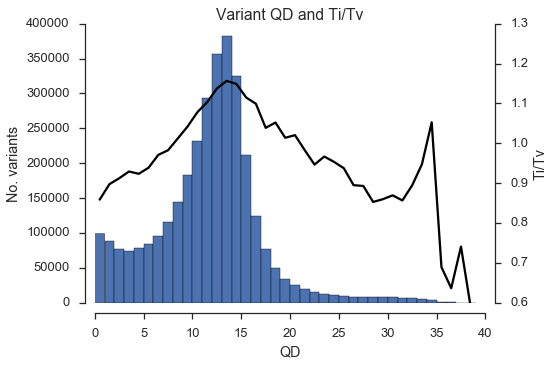

In [26]:
plot_ti_tv('QD', downsample=5, bins=np.arange(0, 40, 1))

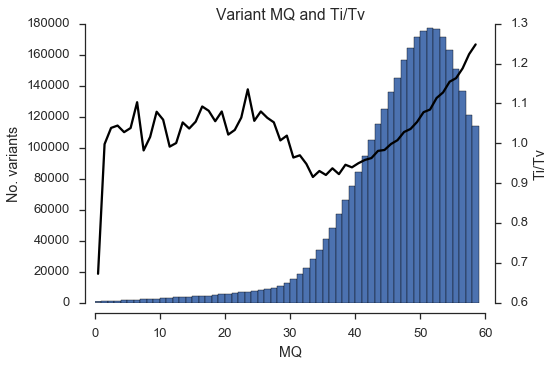

In [27]:
plot_ti_tv('MQ', downsample=5, bins=np.arange(0, 60, 1))

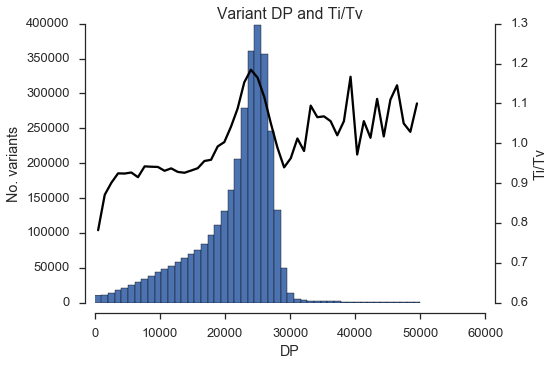

In [28]:
plot_ti_tv('DP', downsample=5, bins=np.linspace(0, 50000, 50))

Ti/Tv is not a simple variable and so some care is required when interpreting these plots. However, we can see that there is a trend towards low Ti/Tv for low values of QD, MQ and DP.

To investigate further, let's look at Ti/Tv in two dimensions. 

In [29]:
def plot_joint_ti_tv(f1, f2, downsample, gridsize=20, mincnt=20, vmin=0.6, vmax=1.4, extent=None):
    fig, ax = plt.subplots()
    sns.despine(ax=ax, offset=10)
    x = variants[f1][:][::downsample]
    y = variants[f2][:][::downsample]
    C = refalt[::downsample]
    im = ax.hexbin(x, y, C=C, reduce_C_function=ti_tv, mincnt=mincnt, extent=extent,
                   gridsize=gridsize, cmap='jet', vmin=vmin, vmax=vmax)
    fig.colorbar(im)
    ax.set_xlabel(f1)
    ax.set_ylabel(f2)
    ax.set_title('Variant %s versus %s and Ti/Tv' % (f1, f2))

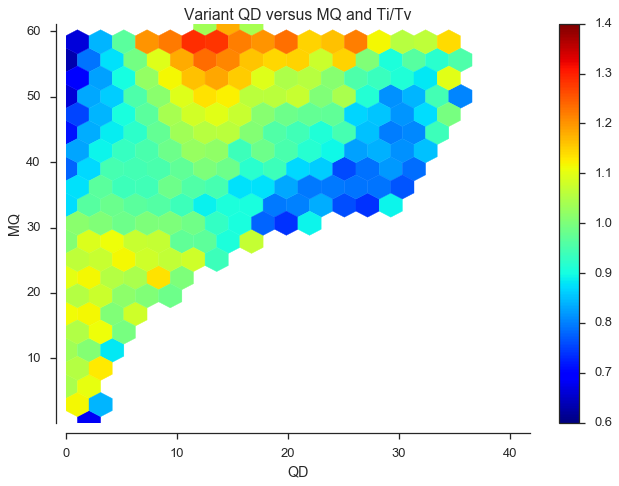

In [30]:
plot_joint_ti_tv('QD', 'MQ', downsample=5, mincnt=400)

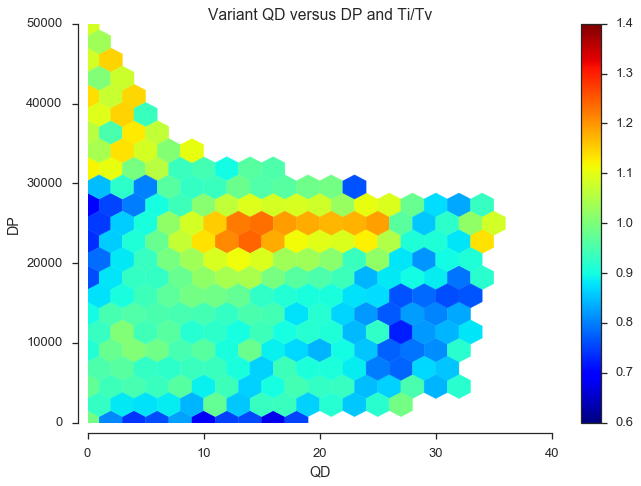

In [31]:
plot_joint_ti_tv('QD', 'DP', downsample=5, mincnt=400, extent=(0, 40, 0, 50000))

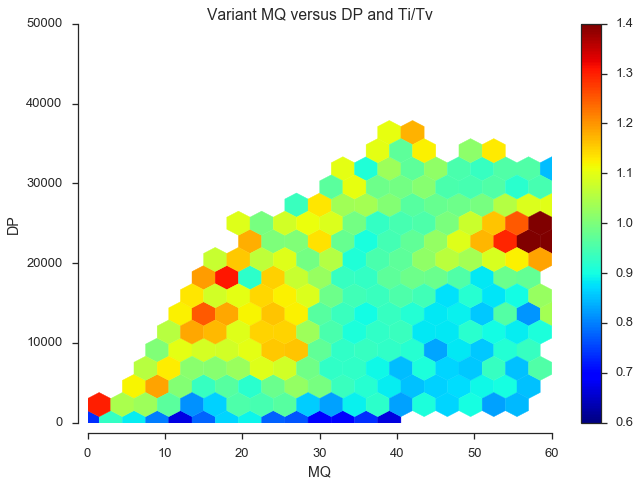

In [32]:
plot_joint_ti_tv('MQ', 'DP', downsample=5, mincnt=400, extent=(0, 60, 0, 50000))

## Filtering variants

There are many possible approaches to filtering variants. The simplest approach is define thresholds on variant attributes like DP, MQ and QD, and exclude SNPs that fall outside of a defined range (a.k.a. "hard filtering"). This is crude but simple to implement and in many cases may suffice. 

Let's implement a simple hard filter, informed by our knowledge of variant quality gained from above.

First, a reminder that we have a table containing all these variant attributes.

In [33]:
variants

POS,REF,ALT,DP,MQ,QD,num_alleles
15,b'G',[b'T' b'' b''],1,14.5,24.188,2
19,b'A',[b'C' b'' b''],2,14.5,21.672,2
20,b'A',[b'G' b'' b''],2,14.5,21.672,2
23,b'A',[b'C' b'' b''],2,13.672,21.672,2
24,b'C',[b'A' b'' b''],2,13.672,21.672,2


Define the hard filter using an expression. This is just a string of Python code, which we will evaluate in a moment.

In [34]:
filter_expression = '(QD > 5) & (MQ > 40) & (DP > 15000) & (DP < 30000)'

Now evaluate the filter using the columns from the table

In [35]:
variant_selection = variants.eval(filter_expression)[:]
variant_selection

array([False, False, False, ..., False, False, False], dtype=bool)

How many variants to we keep?

In [36]:
np.count_nonzero(variant_selection)

11766616

How many variants do we filter out?

In [37]:
np.count_nonzero(~variant_selection)

4670519

Now that we have our variant filter, let's make a new variants table with only rows for variants that pass our filter.

In [38]:
variants_pass = variants.compress(variant_selection)
variants_pass

POS,REF,ALT,DP,MQ,QD,num_alleles
9661,b'G',[b'T' b'' b''],17050,40.312,8.2578,2
9662,b'C',[b'A' b'' b''],17050,40.438,5.3398,2
9664,b'T',[b'A' b'' b''],17085,40.781,5.6484,2
9680,b'A',[b'T' b'' b''],17648,41.875,7.6406,2
9683,b'T',[b'A' b'' b''],17689,41.875,11.227,2


## Subset genotypes

Now that we have some idea of variant quality, let's look at our samples and at the genotype calls.

All data relating to the genotype calls is stored in the HDF5.

In [39]:
calldata = callset[chrom]['calldata']
calldata

<HDF5 group "/3L/calldata" (5 members)>

In [40]:
list(calldata.keys())

['AD', 'DP', 'GQ', 'genotype', 'is_called']

Each of these is a separate dataset in the HDF5 file. To make it easier to work with the genotype dataset, let's wrap it using a class from scikit-allel.

In [41]:
genotypes = allel.GenotypeChunkedArray(calldata['genotype'])
genotypes

,0,1,2,3,4,...,760,761,762,763,764
0,./.,./.,./.,./.,./.,...,./.,./.,./.,./.,./.
1,./.,./.,./.,./.,./.,...,./.,./.,./.,./.,./.
2,./.,./.,./.,./.,./.,...,./.,./.,./.,./.,./.
3,./.,./.,./.,./.,./.,...,./.,./.,./.,./.,./.
4,./.,./.,./.,./.,./.,...,./.,./.,./.,./.,./.


N.B., at this point we have not loaded any data into memory, it is still in the HDF5 file. From the representation above we have some diagnostic information about the genotypes, for example, we have calls for 16,437,135 variants in 765 samples with ploidy 2 (i.e., diploid). Uncompressed these data would be 23.4G but the data are compressed and so actually use 1.2G on disk.

We can also see genotype calls for the first 5 variants in the first and last 5 samples, which are all missing ("./.").

Before we go any furter, let's also pull in some data about the 765 samples we've genotyped.

In [43]:
samples_fn = '/data/coluzzi/ag1000g/data/phase1/release/AR3/samples/samples.meta.txt'
samples = pandas.DataFrame.from_csv(samples_fn, sep='\t')
samples.head()

,ox_code,src_code,sra_sample_accession,population,country,region,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,latitude,longitude
index,,,,,,,,,,,,,,,
0,AB0085-C,BF2-4,ERS223996,BFS,Burkina Faso,Pala,Austin Burt,Sam O'Loughlin,2012,S,F,89905852,28.01,11.150,-4.235
1,AB0087-C,BF3-3,ERS224013,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,116706234,36.76,11.233,-4.472
2,AB0088-C,BF3-5,ERS223991,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,112090460,23.30,11.233,-4.472
3,AB0089-C,BF3-8,ERS224031,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,145350454,41.36,11.233,-4.472
4,AB0090-C,BF3-10,ERS223936,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,105012254,34.64,11.233,-4.472


The "population" column defines which of 9 populations the mosquitoes came from, based on sampling location and species. E.g., "BFM" means *Anopheles coluzzii* mosquitoes from Burkina Faso, "GAS" means *Anopheles gambiae* mosquitoes from Gabon. How many mosquitoes come from each of these populations?

In [44]:
samples.population.value_counts()

CMS    275
UGS    103
BFS     81
BFM     69
AOM     60
GAS     56
GWA     46
KES     44
GNS     31
Name: population, dtype: int64

Let's work with two populations only for simplicity. These are *Anopheles coluzzii* populations from Burkina Faso (BFM) and Angola (AOM).

In [46]:
sample_selection = samples.population.isin({'BFM', 'AOM'}).values
sample_selection[:5]

array([False,  True,  True,  True,  True], dtype=bool)

Now restrict the samples table to only these two populations.

In [47]:
samples_subset = samples[sample_selection]
samples_subset.reset_index(drop=True, inplace=True)
samples_subset.head()

,ox_code,src_code,sra_sample_accession,population,country,region,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,latitude,longitude
0,AB0087-C,BF3-3,ERS224013,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,116706234,36.76,11.233,-4.472
1,AB0088-C,BF3-5,ERS223991,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,112090460,23.30,11.233,-4.472
2,AB0089-C,BF3-8,ERS224031,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,145350454,41.36,11.233,-4.472
3,AB0090-C,BF3-10,ERS223936,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,105012254,34.64,11.233,-4.472
4,AB0091-C,BF3-12,ERS224065,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,98833426,29.97,11.233,-4.472


In [48]:
samples_subset.population.value_counts()

BFM    69
AOM    60
Name: population, dtype: int64

Now let's subset the genotype calls to keep only variants that pass our quality filters and only samples in our two populations of interest. This takes a couple of minutes, so time for a very quick tea break.

In [49]:
%%time
genotypes_subset = genotypes.subset(variant_selection, sample_selection)

CPU times: user 1min 42s, sys: 1.33 s, total: 1min 43s
Wall time: 1min 50s


In [50]:
genotypes_subset

,0,1,2,3,4,...,124,125,126,127,128
0,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0
1,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0
2,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0
3,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0
4,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0


## Sample QC

Before we go any further, let's do some sample QC. This is just to check if any of the 129 samples we're working with have major quality issues that might confound an analysis. 

Compute the percent of missing and heterozygous genotype calls for each sample.

In [51]:
%%time
n_variants = len(variants_pass)
pc_missing = genotypes_subset.count_missing(axis=0)[:] * 100 / n_variants
pc_het = genotypes_subset.count_het(axis=0)[:] * 100 / n_variants

CPU times: user 48.1 s, sys: 392 ms, total: 48.5 s
Wall time: 21 s


Define a function to plot genotype frequencies for each sample.

In [196]:
def plot_genotype_frequency(pc, title):
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.despine(ax=ax, offset=10)
    left = np.arange(len(pc))
    palette = sns.color_palette()
    pop2color = {'BFM': palette[0], 'AOM': palette[1]}
    colors = [pop2color[p] for p in samples_subset.population]
    ax.bar(left, pc, color=colors)
    ax.set_xlim(0, len(pc))
    ax.set_xlabel('Sample index')
    ax.set_ylabel('Percent calls')
    ax.set_title(title)
    handles = [mpl.patches.Patch(color=palette[0]),
               mpl.patches.Patch(color=palette[1])]
    ax.legend(handles=handles, labels=['BFM', 'AOM'], title='Population',
              bbox_to_anchor=(1, 1), loc='upper left')

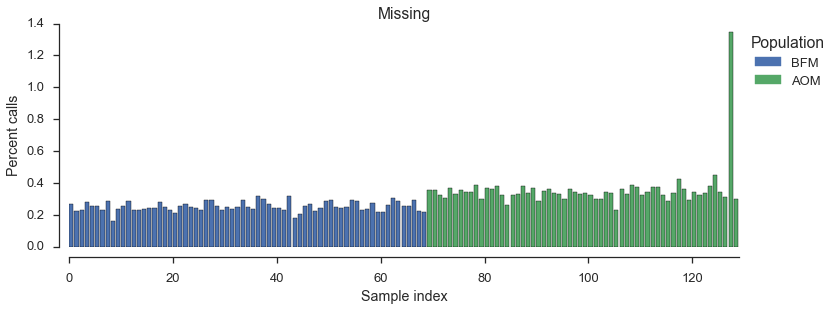

In [197]:
plot_genotype_frequency(pc_missing, 'Missing')

In [198]:
np.argsort(n_missing)[-1]

127

In [199]:
g_strange = genotypes_subset.take([60, 100, 127], axis=1)
g_strange

,0,1,2
0,0/0,0/0,0/0
1,0/0,0/0,0/0
2,0/0,0/0,0/0
3,0/0,0/0,0/0
4,0/0,0/1,0/0


In [200]:
is_missing = g_strange.is_missing()[:]
is_missing

array([[False, False, False],
       [False, False, False],
       [False, False, False],
       ..., 
       [False, False, False],
       [False, False, False],
       [False, False, False]], dtype=bool)

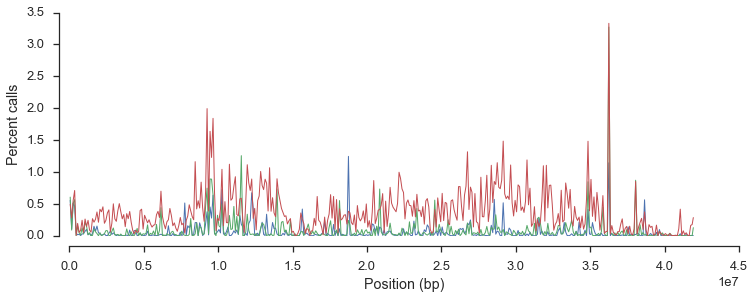

In [202]:
pos = variants_pass['POS'][:]
window_size = 100000
y1, windows, _ = allel.stats.windowed_statistic(pos, is_missing[:, 0], statistic=np.count_nonzero, size=window_size)
y2, windows, _ = allel.stats.windowed_statistic(pos, is_missing[:, 1], statistic=np.count_nonzero, size=window_size)
y3, windows, _ = allel.stats.windowed_statistic(pos, is_missing[:, 2], statistic=np.count_nonzero, size=window_size)
x = windows.mean(axis=1)
fig, ax = plt.subplots(figsize=(12, 4))
sns.despine(ax=ax, offset=10)
ax.plot(x, y1 * 100 / window_size, lw=1)
ax.plot(x, y2 * 100 / window_size, lw=1)
ax.plot(x, y3 * 100 / window_size, lw=1)
ax.set_xlabel('Position (bp)')
ax.set_ylabel('Percent calls');

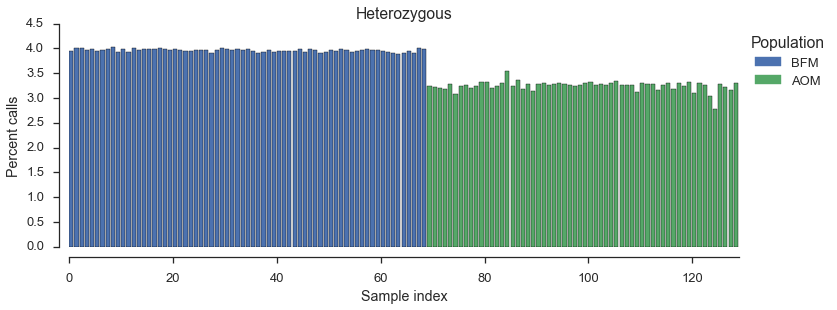

In [203]:
plot_genotype_frequency(pc_het, 'Heterozygous')

### Allele count

In [225]:
subpops = {
    'all': list(range(len(samples_subset))),
    'BFM': samples_subset[samples_subset.population == 'BFM'].index.tolist(),
    'AOM': samples_subset[samples_subset.population == 'AOM'].index.tolist(),
}
subpops['AOM'][:5]

[69, 70, 71, 72, 73]

In [226]:
%%time
ac_subpops = genotypes_subset.count_alleles_subpops(subpops, max_allele=3)

CPU times: user 25.5 s, sys: 196 ms, total: 25.7 s
Wall time: 18.4 s


In [227]:
ac_subpops

all,BFM,AOM
[258 0 0 0],[138 0 0 0],[120 0 0 0]
[258 0 0 0],[138 0 0 0],[120 0 0 0]
[258 0 0 0],[138 0 0 0],[120 0 0 0]
[258 0 0 0],[138 0 0 0],[120 0 0 0]
[256 2 0 0],[138 0 0 0],[118 2 0 0]


In [228]:
ac_subpops['all']

,0,1,2,3
0,258,0,0,0
1,258,0,0,0
2,258,0,0,0
3,258,0,0,0
4,256,2,0,0


### Locate segregating variants

In [229]:
for pop in 'all', 'BFM', 'AOM':
    print(pop, ac_subpops[pop].count_segregating())

all 5240001
BFM 4695733
AOM 2099287


In [230]:
is_seg = ac_subpops['all'].is_segregating()[:]
is_seg

array([False, False, False, ..., False, False, False], dtype=bool)

In [231]:
genotypes_seg = genotypes_subset.compress(is_seg, axis=0)
genotypes_seg

,0,1,2,3,4,...,124,125,126,127,128
0,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0
1,1/1,1/1,1/1,1/1,1/1,...,0/0,0/1,0/0,0/1,0/0
2,0/0,0/0,0/1,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0
3,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0
4,0/1,0/1,0/0,0/0,0/1,...,0/0,0/0,0/0,0/0,0/0


In [232]:
variants_seg = variants_pass.compress(is_seg)
variants_seg

POS,REF,ALT,DP,MQ,QD,num_alleles
9683,b'T',[b'A' b'' b''],17689,41.875,11.227,2
9691,b'C',[b'T' b'' b''],17675,41.75,22.281,2
9712,b'C',[b'T' b'' b''],19548,45.75,11.992,2
9729,b'G',[b'A' b'T' b''],20282,49.188,12.32,3
9773,b'G',[b'A' b'T' b''],22609,54.031,19.047,3


In [233]:
ac_seg = ac_subpops.compress(is_seg)
ac_seg

all,BFM,AOM
[256 2 0 0],[138 0 0 0],[118 2 0 0]
[ 86 172 0 0],[ 1 137 0 0],[85 35 0 0]
[244 14 0 0],[137 1 0 0],[107 13 0 0]
[257 0 1 0],[137 0 1 0],[120 0 0 0]
[235 23 0 0],[115 23 0 0],[120 0 0 0]


### Population differentiation

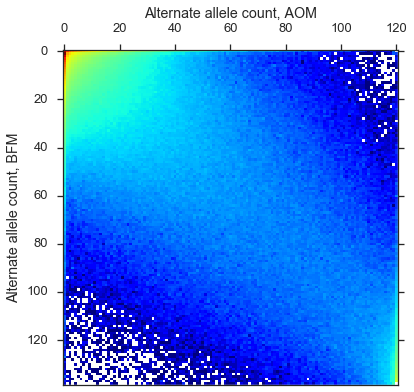

In [242]:
jsfs = allel.stats.joint_sfs(ac_seg['BFM'][:, 1], ac_seg['AOM'][:, 1])
fig, ax = plt.subplots(figsize=(6, 6))
allel.stats.plot_joint_sfs(jsfs, ax=ax)
ax.set_ylabel('Alternate allele count, BFM')
ax.set_xlabel('Alternate allele count, AOM');

In [246]:
fst, fst_se, _, _ = allel.stats.blockwise_hudson_fst(ac_seg['BFM'], ac_seg['AOM'], blen=100000)
print('Fst: %.3f +/- %.3f' % (fst, fst_se))

Fst: 0.109 +/- 0.006


In [252]:
def plot_fst(ac1, ac2, pos, blen=2000):
    
    fst, se, vb, _ = allel.stats.blockwise_hudson_fst(ac1, ac2, blen=blen)
    
    # use the per-block average Fst as the Y coordinate
    y = vb
    
    # use the block centres as the X coordinate
    x = allel.stats.moving_statistic(pos, statistic=lambda v: (v[0] + v[-1]) / 2, size=blen)
    
    # plot
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.despine(ax=ax, offset=10)
    ax.plot(x, y, 'k-', lw=.5)
    ax.set_ylabel('$F_{ST}$')
    ax.set_xlabel('Chromosome %s position (bp)' % chrom)
    ax.set_xlim(0, pos.max())

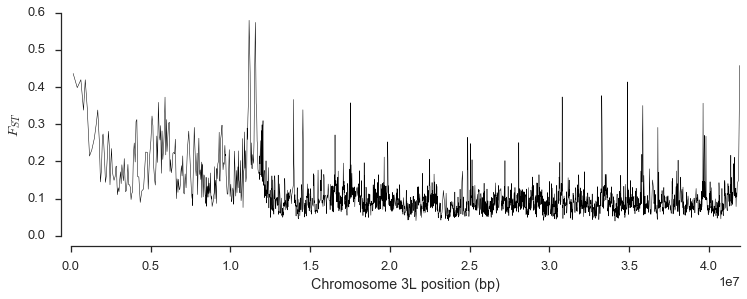

In [253]:
plot_fst(ac_seg['BFM'], ac_seg['AOM'], variants_seg['POS'][:])

### Site frequency spectra

In [259]:
is_biallelic_01 = (ac_seg['all'].allelism()[:] == 2) & (ac_seg['all'].max_allele()[:] == 1)
ac1 = ac_seg['BFM'].compress(is_biallelic_01, axis=0)[:, :2]
ac2 = ac_seg['AOM'].compress(is_biallelic_01, axis=0)[:, :2]
ac1

array([[138,   0],
       [  1, 137],
       [137,   1],
       ..., 
       [136,   0],
       [135,   1],
       [136,   0]], dtype=int32)

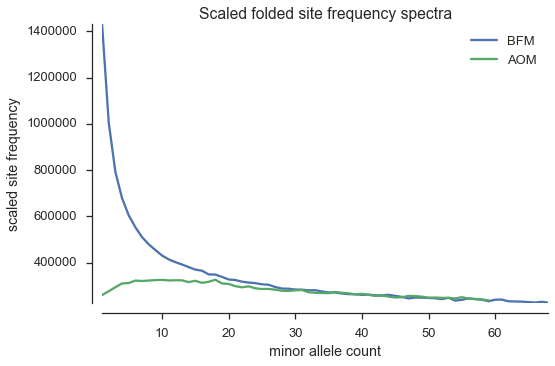

In [266]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.despine(ax=ax, offset=10)
sfs1 = allel.stats.sfs_folded_scaled(ac1)
allel.stats.plot_sfs_folded_scaled(sfs1, ax=ax, label='BFM')
sfs2 = allel.stats.sfs_folded_scaled(ac2)
allel.stats.plot_sfs_folded_scaled(sfs2, ax=ax, label='AOM')
ax.legend()
ax.set_title('Scaled folded site frequency spectra');

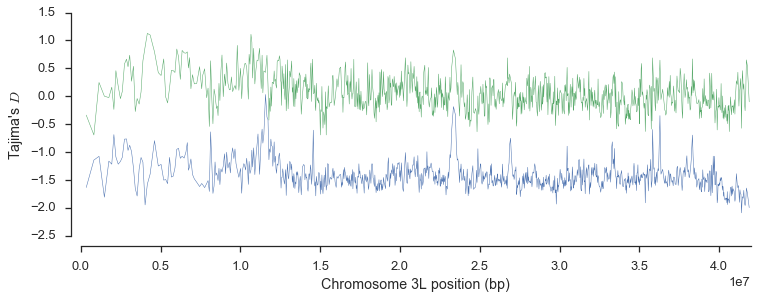

In [287]:
# compute windows with equal numbers of SNPs
windows = allel.stats.moving_statistic(pos, statistic=lambda v: [v[0], v[-1]], size=5000)
x = np.asarray(windows).mean(axis=1)

# compute Tajima's D
y1, _, _ = allel.stats.windowed_tajima_d(pos, ac_seg['BFM'][:], windows=windows)
y2, _, _ = allel.stats.windowed_tajima_d(pos, ac_seg['AOM'][:], windows=windows)

# plot
fig, ax = plt.subplots(figsize=(12, 4))
sns.despine(ax=ax, offset=10)
ax.plot(x, y1, lw=.5, label='BFM')
ax.plot(x, y2, lw=.5, label='AOM')
ax.set_ylabel("Tajima's $D$")
ax.set_xlabel('Chromosome %s position (bp)' % chrom)
ax.set_xlim(0, pos.max());

In [ ]:
# TODO raise issue for moving/blockwise Tajima's D

### Principal components analysis

In [ ]:
# TODO